In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, string
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import joblib

## Lettura Dataset Processato

In [2]:
df = pd.read_csv('../data/preprocessed_dataset.csv')
df.head()

,Unnamed: 0,category,rating,label,text_
0,0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort love pretti
1,1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin 've mine coupl year
2,2,Home_and_Kitchen_5,5.0,CG,pillow save back love look feel pillow
3,3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price
4,4,Home_and_Kitchen_5,5.0,CG,nice set good qualiti set two month


## Drop eventuali celle vuote nel Dataset

In [3]:
df.dropna(inplace=True)

## Definizione Funzione text_process

In [4]:
def text_process(review):
    nopunc = [char for char in review if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

## Creazione di una Matrice Bag-of-Words tramite Pre-elaborazione del Testo e Vettorizzazione

In [5]:
bow_transformer = CountVectorizer(analyzer=text_process)
bow_transformer

CountVectorizer(analyzer=<function text_process at 0x0000021BF4434360>)

In [6]:
bow_transformer.fit(df['text_'])

CountVectorizer(analyzer=<function text_process at 0x0000021BF4434360>)

In [7]:
review4 = df['text_'][3]
review4

'miss inform use great product price'

In [8]:
bow_msg4 = bow_transformer.transform([review4])
print(bow_msg4)
print(bow_msg4.shape)

  (0, 13643)	1
  (0, 15885)	1
  (0, 19892)	1
  (0, 23889)	1
  (0, 24019)	1
  (0, 32221)	1
(1, 34489)


There are 6 unique words in the 4th review.

In [9]:
bow_reviews = bow_transformer.transform(df['text_'])

In [10]:
print("Shape of Bag of Words Transformer for the entire reviews corpus:",bow_reviews.shape)
print("Amount of non zero values in the bag of words model:",bow_reviews.nnz)

Shape of Bag of Words Transformer for the entire reviews corpus: (40431, 34489)
Amount of non zero values in the bag of words model: 1001954


In [11]:
print("Sparsity:",np.round((bow_reviews.nnz/(bow_reviews.shape[0]*bow_reviews.shape[1]))*100,2))

Sparsity: 0.07


## Trasformazione in TF-IDF del testo delle Recensioni da Bag-of-Words

In [12]:
tfidf_transformer = TfidfTransformer().fit(bow_reviews)
tfidf_rev4 = tfidf_transformer.transform(bow_msg4)
print(bow_msg4)

  (0, 13643)	1
  (0, 15885)	1
  (0, 19892)	1
  (0, 23889)	1
  (0, 24019)	1
  (0, 32221)	1


In [13]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['mango']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['book']])

10.91422964906803
2.821684385176731


In [14]:
tfidf_reviews = tfidf_transformer.transform(bow_reviews)
print("Shape:",tfidf_reviews.shape)
print("No. of Dimensions:",tfidf_reviews.ndim)

Shape: (40431, 34489)
No. of Dimensions: 2


# Creating training and testing data

In [15]:
review_train, review_test, label_train, label_test = train_test_split(df['text_'],df['label'],test_size=0.2)

# Multinomial Naive Bayes Algorithm Training

In [16]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [17]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000021BF4434360>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [18]:
predictions = pipeline.predict(review_test)
predictions

array(['CG', 'CG', 'OR', ..., 'OR', 'CG', 'CG'], dtype='<U2')

In [19]:
print('Classification Report:',classification_report(label_test,predictions))
print('Confusion Matrix:',confusion_matrix(label_test,predictions))
print('Accuracy Score:',accuracy_score(label_test,predictions))

Classification Report:               precision    recall  f1-score   support

          CG       0.83      0.88      0.85      4036
          OR       0.88      0.82      0.85      4051

    accuracy                           0.85      8087
   macro avg       0.85      0.85      0.85      8087
weighted avg       0.85      0.85      0.85      8087

Confusion Matrix: [[3566  470]
 [ 742 3309]]
Accuracy Score: 0.8501298380116236


In [20]:
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,predictions)*100,2)) + '%')

Model Prediction Accuracy: 85.01%


In [21]:
joblib.dump(pipeline, '../models/multinomialNB_model.pkl')

['../models/multinomialNB_model.pkl']

# Random Forest Algorithm Training

In [22]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
])

In [23]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000021BF4434360>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [24]:
rfc_pred = pipeline.predict(review_test)
rfc_pred

array(['CG', 'CG', 'OR', ..., 'OR', 'CG', 'CG'], dtype=object)

In [25]:
print('Classification Report:',classification_report(label_test,rfc_pred))
print('Confusion Matrix:',confusion_matrix(label_test,rfc_pred))
print('Accuracy Score:',accuracy_score(label_test,rfc_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,rfc_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.82      0.88      0.85      4036
          OR       0.87      0.81      0.84      4051

    accuracy                           0.85      8087
   macro avg       0.85      0.85      0.85      8087
weighted avg       0.85      0.85      0.85      8087

Confusion Matrix: [[3558  478]
 [ 768 3283]]
Accuracy Score: 0.8459255595400025
Model Prediction Accuracy: 84.59%


In [26]:
joblib.dump(pipeline, '../models/random_forest_classifier__model.pkl')

['../models/random_forest_classifier__model.pkl']

# Decision Tree Classifier Algorithm Training

In [27]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',DecisionTreeClassifier())
])

In [28]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000021BF4434360>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', DecisionTreeClassifier())])

In [29]:
dtree_pred = pipeline.predict(review_test)
dtree_pred

array(['OR', 'CG', 'OR', ..., 'CG', 'OR', 'CG'], dtype=object)

In [30]:
print('Classification Report:',classification_report(label_test,dtree_pred))
print('Confusion Matrix:',confusion_matrix(label_test,dtree_pred))
print('Accuracy Score:',accuracy_score(label_test,dtree_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,dtree_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.74      0.75      0.75      4036
          OR       0.75      0.74      0.74      4051

    accuracy                           0.74      8087
   macro avg       0.74      0.74      0.74      8087
weighted avg       0.74      0.74      0.74      8087

Confusion Matrix: [[3043  993]
 [1073 2978]]
Accuracy Score: 0.7445282552244343
Model Prediction Accuracy: 74.45%


In [31]:
joblib.dump(pipeline, '../models/decision_tree_classifier_model.pkl')

['../models/decision_tree_classifier_model.pkl']

# KNeighbors Classifier Algorithm Training

In [32]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',KNeighborsClassifier(n_neighbors=2))
])

In [33]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000021BF4434360>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', KNeighborsClassifier(n_neighbors=2))])

In [34]:
knn_pred = pipeline.predict(review_test)
knn_pred

array(['CG', 'CG', 'OR', ..., 'OR', 'CG', 'CG'], dtype=object)

In [35]:
print('Classification Report:',classification_report(label_test,knn_pred))
print('Confusion Matrix:',confusion_matrix(label_test,knn_pred))
print('Accuracy Score:',accuracy_score(label_test,knn_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,knn_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.54      0.97      0.70      4036
          OR       0.86      0.18      0.30      4051

    accuracy                           0.57      8087
   macro avg       0.70      0.58      0.50      8087
weighted avg       0.70      0.57      0.50      8087

Confusion Matrix: [[3919  117]
 [3320  731]]
Accuracy Score: 0.5749969086187708
Model Prediction Accuracy: 57.5%


In [36]:
joblib.dump(pipeline, '../models/kneighbors_classifier_model.pkl')

['../models/kneighbors_classifier_model.pkl']

# Support Vector Classifier Algorithm Training

In [37]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',SVC())
])

In [38]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000021BF4434360>)),
                ('tfidf', TfidfTransformer()), ('classifier', SVC())])

In [39]:
svc_pred = pipeline.predict(review_test)
svc_pred

array(['CG', 'CG', 'OR', ..., 'OR', 'CG', 'CG'], dtype=object)

In [40]:
print('Classification Report:',classification_report(label_test,svc_pred))
print('Confusion Matrix:',confusion_matrix(label_test,svc_pred))
print('Accuracy Score:',accuracy_score(label_test,svc_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,svc_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.90      0.87      0.89      4036
          OR       0.88      0.90      0.89      4051

    accuracy                           0.89      8087
   macro avg       0.89      0.89      0.89      8087
weighted avg       0.89      0.89      0.89      8087

Confusion Matrix: [[3514  522]
 [ 391 3660]]
Accuracy Score: 0.8871027575120564
Model Prediction Accuracy: 88.71%


In [41]:
joblib.dump(pipeline, '../models/svc_model.pkl')

['../models/svc_model.pkl']

# Logistic Regression Training

In [42]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',LogisticRegression())
])

In [43]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000021BF4434360>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', LogisticRegression())])

In [44]:
lr_pred = pipeline.predict(review_test)
lr_pred

array(['CG', 'CG', 'OR', ..., 'OR', 'CG', 'CG'], dtype=object)

In [45]:
print('Classification Report:',classification_report(label_test,lr_pred))
print('Confusion Matrix:',confusion_matrix(label_test,lr_pred))
print('Accuracy Score:',accuracy_score(label_test,lr_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,lr_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.88      0.86      0.87      4036
          OR       0.86      0.88      0.87      4051

    accuracy                           0.87      8087
   macro avg       0.87      0.87      0.87      8087
weighted avg       0.87      0.87      0.87      8087

Confusion Matrix: [[3451  585]
 [ 487 3564]]
Accuracy Score: 0.8674415728947694
Model Prediction Accuracy: 86.74%


In [46]:
joblib.dump(pipeline, '../models/logisic_regression_model.pkl')

['../models/logisic_regression_model.pkl']

# Conclusion

Stampa dell'accuratezza di tutti i modelli, più stampa di un grafico per il confronto 

In [47]:
print('Performance of various ML models:')
print('\n')
print('Logistic Regression Prediction Accuracy:',str(np.round(accuracy_score(label_test,lr_pred)*100,2)) + '%')
print('K Nearest Neighbors Prediction Accuracy:',str(np.round(accuracy_score(label_test,knn_pred)*100,2)) + '%')
print('Decision Tree Classifier Prediction Accuracy:',str(np.round(accuracy_score(label_test,dtree_pred)*100,2)) + '%')
print('Random Forests Classifier Prediction Accuracy:',str(np.round(accuracy_score(label_test,rfc_pred)*100,2)) + '%')
print('Support Vector Machines Prediction Accuracy:',str(np.round(accuracy_score(label_test,svc_pred)*100,2)) + '%')
print('Multinomial Naive Bayes Prediction Accuracy:',str(np.round(accuracy_score(label_test,predictions)*100,2)) + '%')

Performance of various ML models:


Logistic Regression Prediction Accuracy: 86.74%
K Nearest Neighbors Prediction Accuracy: 57.5%
Decision Tree Classifier Prediction Accuracy: 74.45%
Random Forests Classifier Prediction Accuracy: 84.59%
Support Vector Machines Prediction Accuracy: 88.71%
Multinomial Naive Bayes Prediction Accuracy: 85.01%


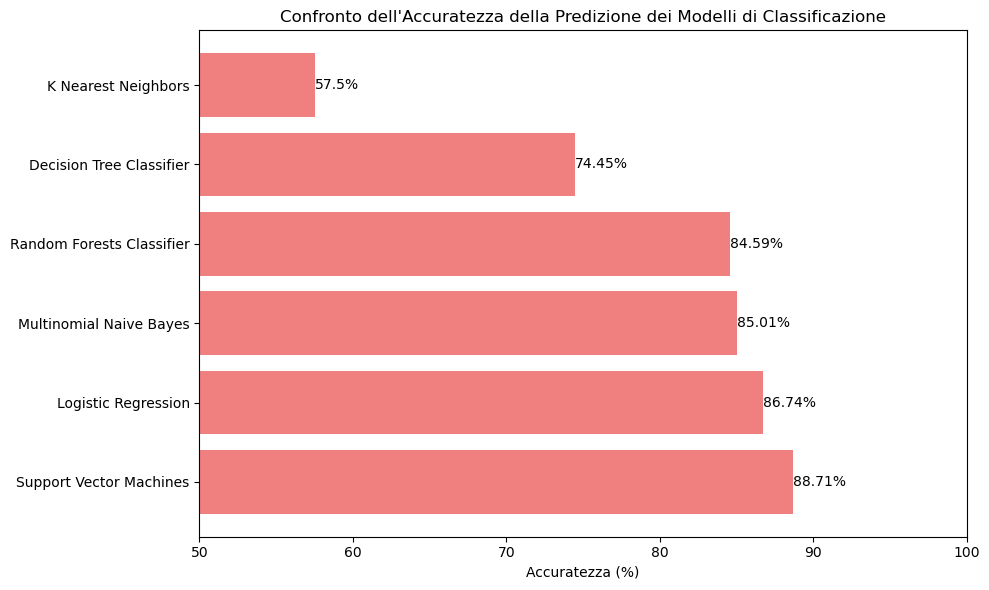